# <s>Космический</s>Финальный проект

Менеджеры из "Космических Братьев" хотят узнать, какой рекламный канал является самым приоритетным (или наоборот, при прочих равных), для чего попросили нас проанализировать поведение первых пользователей.

[Презентация](https://drive.google.com/file/d/1PQFu3cKuciT7r-u0vEPprz_EQPAGBlbz/view?usp=sharing)

---

## Структура проекта
1. [Начало](#inception)
1. [Предобработка](#preprocessing)
1. [EDA](#eda)
1. [Гипотезы](#hypothesis)
1. [Выводы](#conclusions)

---

## Начало
<a name='inception' id='inception'></a>
Перестанем прокрастинировать и импортируем библиотеки (хотя бы)

In [1]:
!pip install pandas seaborn --upgrade -q

In [2]:
import re
from os import environ

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
pd.set_option(
    'display.float_format', lambda x: '%.3f' % x
)

sns.set(
    rc = {
        'figure.figsize': (17, 7),
        'figure.dpi': 80,
        'axes.grid': True,
        'axes.grid.axis': 'x',
        'axes.grid.which': 'both',
        'grid.alpha': .4,
        'xtick.minor.visible': True,
        },
    palette = 'colorblind',
    style = 'ticks'
)

In [4]:
def read_csv(func: "pd.read_csv" = pd.read_csv) -> pd.DataFrame:
    """Wrapper for pd.read_csv."""

    def wrapper(*args, **kwargs: "pd.read_csv parameters") -> pd.DataFrame:
        """
        Return a DataFrame from csv with true and ordered columns and sort by
        datetime, and display 5 randow rows and df.info().
        """
        df = func(*args, **kwargs)

        if kwargs.get("names", None) is None:
            df.columns = [
                re.sub("([a-z])([A-Z]+)", r"\1_\2", col)
                .strip()
                .lower()
                .replace(" ", "_")
                for col in df.columns
            ]

        parse_dates = kwargs.get("parse_dates", None)
        if parse_dates is not None and df.select_dtypes("datetime").isnull:
            df.iloc[:, parse_dates[0]] = pd.to_datetime(
                df.iloc[:, parse_dates[0]], unit="s"
            )

        if not df.select_dtypes("datetime").isnull:
            date_column = df.select_dtypes("datetime").columns[0]
            df = df.sort_values(date_column).reset_index(drop=True)

        columns_indeces = kwargs.get("usecols", np.arange(df.shape[1]))
        df = df.iloc[:, columns_indeces]

        display(df.sample(5, random_state=42).sort_index())
        print("---------------------------------")
        display(df.describe())
        print("---------------------------------")
        df.info(memory_usage="deep")

        return df

    return wrapper


true_read_csv = read_csv()

In [5]:
PATH = environ.get('GAME_ACTIONS', '/datasets/game_actions.csv')

df = true_read_csv(
    filepath_or_buffer = PATH,
    parse_dates = [0],
    )

,event_datetime,event,building_type,user_id,project_type
16232,2020-05-05 21:20:14,building,assembly_shop,4048f2b5-b66e-4a0e-9f57-018a24606f0a,NaN
31495,2020-05-07 09:46:44,building,assembly_shop,ff28dc9f-01ef-4a55-a21d-7bbdf36bb508,NaN
63129,2020-05-09 23:52:39,building,spaceport,c9f8cc33-5d7a-4842-8946-58167bf6cec9,NaN
81302,2020-05-11 08:29:47,building,spaceport,59fded0d-ba20-42d6-b733-d951c9aecab6,NaN
82140,2020-05-11 10:51:20,building,spaceport,58b0c0da-3af6-4365-ab1d-b0b95c6f9f7d,NaN


---------------------------------


,event_datetime,event,building_type,user_id,project_type
count,135640,135640,127957,135640,1866
unique,128790,3,3,13576,1
top,2020-05-09 12:35:56,building,spaceport,bf542075-e3a2-4e79-82d8-3838e86d2a25,satellite_orbital_assembly
freq,4,127957,59325,22,1866
first,2020-05-04 00:00:01,NaN,NaN,NaN,NaN
last,2020-06-05 12:32:49,NaN,NaN,NaN,NaN


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135640 non-null  datetime64[ns]
 1   event           135640 non-null  object        
 2   building_type   127957 non-null  object        
 3   user_id         135640 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 34.3 MB


Имеем пропуски в полях *building_type* и *project_type*. В последнем, к тому же, лежит только одно значение (целевое *satellite_orbital_assembly*). Можно заменить его флагом.
<br>
Считаем также файл со списком пользователей:

In [6]:
PATH = environ.get('USER_SOURCE', '/datasets/user_source.csv')

users = true_read_csv(
    filepath_or_buffer = PATH,
    )

,user_id,source
749,0db704c1-3e8c-482e-8968-52a19b22e564,yandex_direct
2980,36819063-54d7-42ca-ab4a-1fdb6522c504,instagram_new_adverts
8913,a78cda94-35c1-4dd2-a9f1-54619216e03e,instagram_new_adverts
9440,b20fd385-8818-450e-a899-21ee3c7ff460,yandex_direct
12618,ede65546-ef1f-4efe-aadd-0bee68e7527b,facebook_ads


---------------------------------


,user_id,source
count,13576,13576
unique,13576,4
top,0001f83c-c6ac-4621-b7f0-8a28b283ac30,yandex_direct
freq,1,4817


---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 2.2 MB


Считаем *costs*:

In [7]:
costs = pd.read_csv(
    environ.get('AD_COSTS', '/datasets/ad_costs.csv'),
    parse_dates = [1]
)

---

## Предобработка
<a name='preprocessing' id='preprocessing'></a>
Уберём мусор (если найдём), сделаем удобно (если сможем)

Удалим грубые дубликаты в *df* (в users их нет, по describe сразу было бы видно):

In [8]:
df = df.drop_duplicates().reset_index(drop=True)

Переименуем некоторе поля для удобства:

In [9]:
df = df.rename(columns={'event_datetime': 'dt'})

Посмотрим на значения во всех полях *df*:

In [10]:
for col in df:
    if col is 'dt': continue
    print(df[col].value_counts(), '\n', '_'*50)

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64 
 __________________________________________________
spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64 
 __________________________________________________
bf542075-e3a2-4e79-82d8-3838e86d2a25    22
d6aca06a-cd75-4cd8-b8cd-240a3c163884    22
ff841992-d93b-462e-bc6e-18c24a514f36    22
45935e5d-8f50-4176-83d3-fd545bb2015f    21
4f57b9dc-faa4-4ced-8c6f-1098d612438c    21
                                        ..
1cd22d84-9a82-402a-86ee-185e76eb7a6d     1
29ecf191-5706-420f-be38-28d52abbb069     1
d7c40393-6ac1-4a57-9d80-5ecdfe231e7b     1
7c2021b7-1241-410d-80aa-25cfc8ee720d     1
f6a91a2f-b1dd-4db2-bf11-532c8f893d24     1
Name: user_id, Length: 13576, dtype: int64 
 __________________________________________________
satellite_orbital_assembly    1866
Name: project_type, dtype: int64 
 _______________________________________

Мусора по полям не видно.
<br>
Выведем день события в отдельное поле и создадим отдельное поле для часа события:

In [11]:
df['day'] = df['dt'].astype('datetime64[D]')
df['hour'] = df['dt'].dt.hour

В таблице *users* добавим флаг завершения уровня и поле со способом завершения:

In [12]:
users = users.join(
    df.groupby('user_id')['event']
    .apply(lambda x: True if 'finished_stage_1' in x.tolist() else False)
    .rename('finished'),
    on='user_id',
)

FINISH = users[users['finished']]['user_id']

In [13]:
filter = df[df['project_type'].notna()]['user_id'].unique()
users.loc[users['user_id'].isin(filter), 'how'] = 'project'

In [14]:
filter = np.logical_xor(users['finished'], users['how'].fillna(False).astype('bool'))
users.loc[filter, 'how'] = 'win'

In [15]:
users = users.fillna({'how': 'not'})

Добавим так же первый день для каждого игрока, время до окончания уровня и последний день активности для тех, кто не закончил уровень:

In [16]:
users = users.join(
    df.astype({'dt': 'datetime64[D]'})
    .groupby('user_id')['dt']
    .apply(lambda x: x.iloc[0])
    .rename('first_day'),
    on='user_id',
)

users = users.join(
    df.query('user_id in @FINISH')
    .groupby('user_id')
    .apply(lambda x: (x['dt'].iloc[-1] - x['dt'].iloc[0]))
    .rename('time_to_finish'),
    on='user_id',
)

users = users.join(
    df.astype({'dt': 'datetime64[D]'})
    .groupby('user_id')['dt']
    .apply(lambda x: x.iloc[-1])
    .rename('last_day'), 
    on='user_id'
    )

Оставим от названия каналов только сам канал, убрав уточнение (всё равно это просто 4 рекламных канала):

In [17]:
for item in (users, costs):
    item['source'] = item['source'].apply(lambda x: x.split('_')[0])

Рассчитаем кумулятивную выручку для каждого канала:

In [18]:
costs['cum_cost'] = costs.groupby('source')['cost'].transform('cumsum')

Добавим также канал в *df*:

In [19]:
df = df.merge(users[['user_id', 'source']], on = 'user_id')

---

## EDA
<a name='eda' id='eda'></a>
Посмотрим на разные штуки, построим разные графики

Смотреть на различные пользовательские метрики (DAU, RR) и их динамику во времени особо смысла нет, так как у нас данные всего одной недельной когорты и только для первого уровня, поэтому будем придумывать что-то другое для оценки источников.

Для начала посмотрим на распределение пользователей по ним:

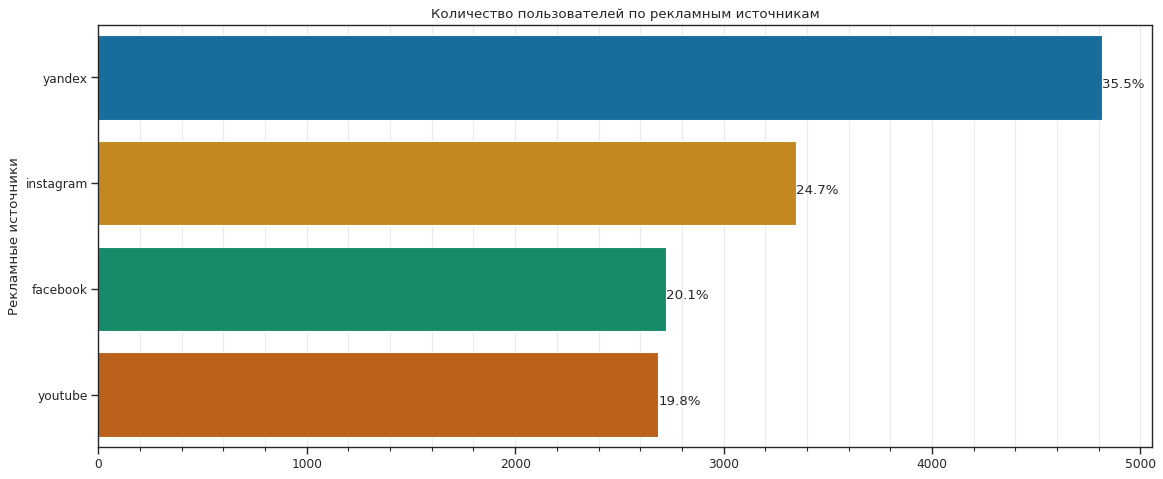

In [20]:
data = users.groupby('source')['user_id'].nunique().sort_values(ascending=False)

ax = sns.barplot(
    y = data.index,
    x = data,
    order = data.index,
)

for rect in ax.patches:
    ax.text(
        x = rect.get_width(),
        y = rect.get_y() + rect.get_height() / 1.6,
        s = '{:.1%}'.format(rect.get_width() / df['user_id'].nunique()),
    )

plt.title('Количество пользователей по рекламным источникам')
plt.xlabel('')
plt.ylabel('Рекламные источники')

plt.show()

С хорошим отрывом лидирует *яндекс*. Посмотрим, какой источник сколько стоил:

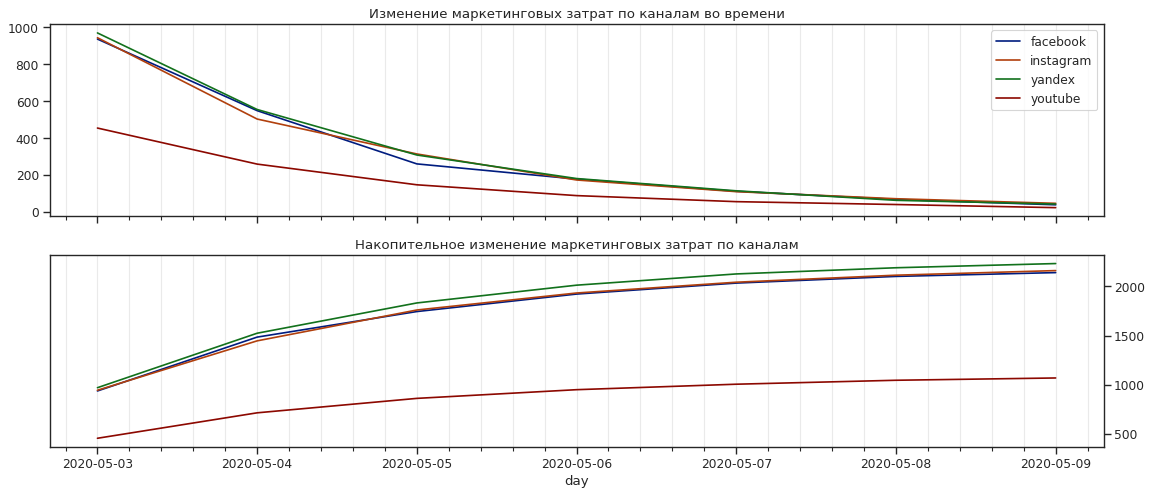

In [21]:
fig, axes = plt.subplots(2, 1)

for ax, col in zip(axes.flat, ('cost', 'cum_cost')):
    sns.lineplot(
        data = costs,
        x = 'day',
        y = col,
        hue = 'source',
        ci = None,
        palette = 'dark',
        ax = ax
    )
    if col == 'cost':
        ax.set(
            xticklabels = '',
            xlabel = '',
            ylabel = '',
            title = 'Изменение маркетинговых затрат по каналам во времени'
            )
        ax.legend(loc='upper right')
        continue
    
    ax.yaxis.tick_right()
    ax.set(
        title = 'Накопительное изменение маркетинговых затрат по каналам',
        ylabel = ''
        )
    ax.legend().remove()

По накопительному графику можно сразу увидеть, что *яндекс*, как самый затратный, закономерно дал больше всех пользователей, а *ютуб* - наоборот. Однако с *фэйсбуком* ситуация отличается - по затратам он почти как *яндекс*, тогда как по пользователям - лишь слегка обогнал *ютуб*. *Инстаграм* находится где-то посередине.
Посмотрим на CAC для каждого канала:

In [22]:
CAC = (
    costs.groupby('source')['cost'].sum().to_frame()
    .join(users.groupby('source')['user_id'].nunique())
    .apply(lambda x: x['cost'] / x['user_id'], axis=1)
    .rename('cac')
    )

CAC

source
facebook    0.785
instagram   0.646
yandex      0.464
youtube     0.398
Name: cac, dtype: float64

Оказыается, игроки из фэйсбука ещё и в два раза дороже ютуба, что делает его самым дорогим каналом.
<br>
Посмотрим на средний CAC:

In [23]:
costs['cost'].sum() / df['user_id'].nunique()

0.5600749106355349

Так как никакой информации о монетизации у нас нет, рассчитаем минимальную стоимость показа рекламы для пользователя (сколько нам надо получать с просмотра, чтобы пользователь окупился за первый уровень). Для этого, исходя из того, что рекламу предполагается показывать на экране выбора объекта для строительства, нужно немного углубиться в постройки на первом уровне. 
<br>
Посмотрим, кто сколько строит:

In [24]:
df.groupby('user_id')['building_type'].count().describe()

count   13576.000
mean        9.425
std         3.861
min         1.000
25%         6.000
50%        10.000
75%        12.000
max        20.000
Name: building_type, dtype: float64

Видно, что каждый игрок построил хотя бы одну постройку, среднее количество - 9 построек, максимальное - 20. Распределение похоже на нормальное, так как медиана рядом со средней. Посмотрим на то же самое в разрезе факта прохождения уровня:

In [25]:
x = (
    df.query('user_id not in @FINISH')
    .groupby('user_id')['building_type']
    .count()
    .describe()
    .rename('not_finished')
)
df.query('user_id in @FINISH').groupby('user_id')[
    'building_type'
].count().describe().rename('finished').to_frame().join(x)


,finished,not_finished
count,5817.000,7759.000
mean,10.450,8.657
std,3.184,4.136
min,2.000,1.000
25%,9.000,5.000
50%,11.000,8.000
75%,12.000,12.000
max,20.000,20.000


Видно, что у тех, кто прошёл первый уровень, количество построек в среднем больше, чем у других игроков.
<br>
Посчитаем минимальную цену показа:

In [26]:
CAC = CAC.to_frame().join(
    df.groupby(['source', 'user_id'])['building_type']
    .count()
    .mean(level=0)
    .rename('build_cnt')
)

CAC['min_price'] = CAC['cac'] / CAC['build_cnt']

CAC

,cac,build_cnt,min_price
source,,,
facebook,0.785,9.586,0.082
instagram,0.646,9.506,0.068
yandex,0.464,9.349,0.050
youtube,0.398,9.299,0.043


In [27]:
(df.groupby(['source', 'user_id'])['building_type']
    .count()
    .mean(level=0)
    .rename('build_cnt'))

source
facebook    9.586
instagram   9.506
yandex      9.349
youtube     9.299
Name: build_cnt, dtype: float64

Cредний показатель:

In [28]:
(costs['cost'].sum() / df['user_id'].nunique()) / df.groupby('user_id')[
    'building_type'
].count().mean()

0.05942337199340415

Добавим для наглядности ещё количество игроков в табличку:

In [29]:
CAC = CAC.join(users.groupby('source')['user_id'].count().rename('cnt_users'))

Получается, чтобы пользователь, пришедший из фейсбука, начал приносить деньги, нужно чтобы стоимость просмотра рекламы была выше 0.082, для ютуба же эта цифра в 2 раза ниже. В среднем цена показа должна быть выше 0.06.

Посмотрим теперь, какое количество времени надо игрокам, чтобы пройти первый уровень:

In [30]:
df.query("user_id in @FINISH").groupby('user_id').apply(lambda x: (x['dt'].iloc[-1] - x['dt'].iloc[0]).ceil('D')).describe()

count                          5817
mean     12 days 08:41:35.306859205
std       4 days 01:55:45.409398676
min                 1 days 00:00:00
25%                10 days 00:00:00
50%                12 days 00:00:00
75%                15 days 00:00:00
max                31 days 00:00:00
dtype: object

Среднее количество времени, которое нужно игрокам на прохождение первого уровня - 12 дней.
Посмотрим на то, сколько дней нужно игрокам, чтобы потерять интерес к игре (не пройти первый уровень и перестать заходить):

In [33]:
df.query("user_id not in @FINISH").groupby('user_id').apply(lambda x: (x['dt'].iloc[-1] - x['dt'].iloc[0]).ceil('D')).describe()

count                          7759
mean     10 days 06:40:19.177729088
std       4 days 08:41:39.199758156
min                 0 days 00:00:00
25%                 7 days 00:00:00
50%                10 days 00:00:00
75%                13 days 00:00:00
max                30 days 00:00:00
dtype: object

Игроки перестают играть быстрее, чем заканчивают уровень (вот это открытие :D).
<br>
Посмотрим на то же самое, но в разрезе рекламных источников:

In [35]:
result = pd.DataFrame()
for source in df['source'].unique():
    temp = df.query("user_id in @FINISH and source == @source").groupby('user_id').apply(lambda x: (x['dt'].iloc[-1] - x['dt'].iloc[0]).ceil('D')).describe().rename(source)
    result = result.join(temp, how='right')

result

,youtube,facebook,instagram,yandex
count,1159,1150,1466,2042
mean,12 days 09:40:13.459879206,12 days 08:22:07.304347826,12 days 09:46:24.720327421,12 days 07:32:43.956904995
std,4 days 01:05:02.802771451,4 days 01:31:34.246002185,4 days 00:55:29.991411320,4 days 03:23:50.093822051
min,1 days 00:00:00,2 days 00:00:00,1 days 00:00:00,1 days 00:00:00
25%,10 days 00:00:00,10 days 00:00:00,10 days 00:00:00,10 days 00:00:00
50%,12 days 00:00:00,12 days 00:00:00,12 days 00:00:00,12 days 00:00:00
75%,15 days 00:00:00,15 days 00:00:00,15 days 00:00:00,15 days 00:00:00
max,28 days 00:00:00,31 days 00:00:00,31 days 00:00:00,31 days 00:00:00


Источники почти никак не отличаются во времени оттока игроков.
<br>
Попробуем это визуализировать:

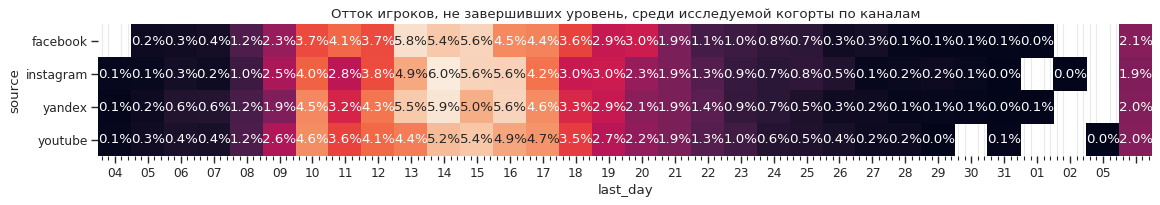

In [36]:
data = (
    users[~users['finished']][['source', 'user_id', 'first_day', 'last_day']]
    .pivot_table(
        index='source', columns='last_day', values='user_id', aggfunc='nunique'
    )
    .apply(lambda x: x / users.groupby('source')['user_id'].nunique())
)

data['mean'] = data.mean(axis=1)
ax = sns.heatmap(data=data, square=True, cbar=None, annot=True, fmt='.1%')
plt.xticks(rotation=0)
ax.set_xticklabels(
    item.get_text()[8:10] for item in ax.get_xticklabels() if item.get_text()
)

plt.title('Отток игроков, не завершивших уровень, среди исследуемой когорты по каналам')
plt.show()

Посмотрим на среднее время прохождения первого уровня в зависимости от стратегии:

In [37]:
temp = users[users['how']=='project']['time_to_finish'].describe().rename(
    'by_station'
).to_frame().join(users[users['how']=='win']['time_to_finish'].describe().rename('by_win'))

temp

,by_station,by_win
count,1866,3951
mean,13 days 11:00:49.135048231,11 days 02:30:24.076183244
std,3 days 12:11:01.977069676,4 days 02:17:54.287406787
min,5 days 03:22:27,0 days 09:39:01
25%,10 days 22:49:58.750000,8 days 07:01:19.500000
50%,13 days 00:45:41,10 days 19:01:37
75%,15 days 13:47:23.750000,13 days 10:33:17.500000
max,29 days 03:13:43,30 days 21:58:53


Победой над другим игроком уровень заканчивают в среднем быстрее, чем реализацией проекта. Убедимся в этом с помощью стат.тестов.

Так же посмотрим на распределение количества построек по рекламным каналам:

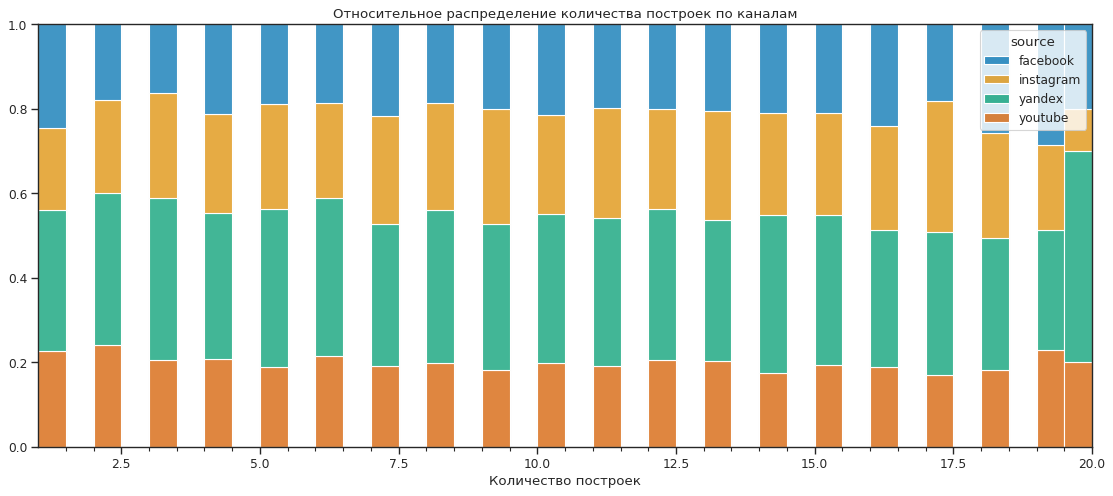

In [44]:
sns.histplot(
    data = df.groupby(['source', 'user_id'])['building_type'].count().reset_index(),
    x = 'building_type',
    hue = 'source',
    multiple = 'fill'
)

plt.title('Относительное распределение количества построек по каналам')
plt.ylabel('')
plt.xlabel('Количество построек')
plt.show()

И на конверсию в прохождение уровня по каналам и предпочтительную стратегию:

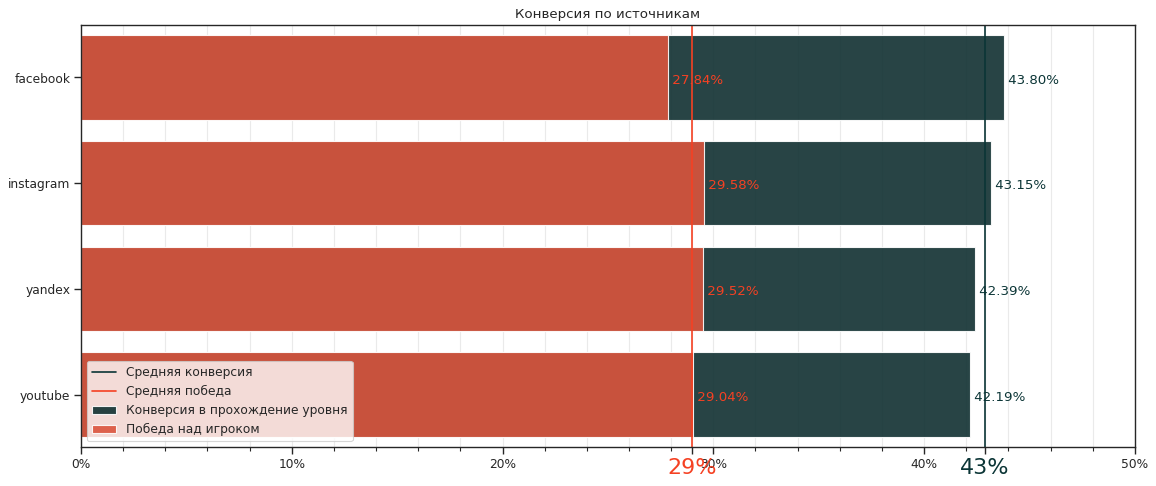

In [34]:
data = (users.groupby('source')['finished'].mean()
        .sort_values(ascending=False)
        .reset_index())
ax = sns.barplot(
    data = data,
    y = 'source',
    x = 'finished',
    color = '#0b3536',
    label = 'Конверсия в прохождение уровня',
    alpha = .9
)
mean = data['finished'].mean()
plt.axvline(mean, color='#0b3536', label='Средняя конверсия')

plt.xticks(ticks=np.append(plt.xticks()[0], mean))
plt.gca().get_xticklabels()[-1].set(color = '#0b3536', size=20) 

data = ((
    users.query("how == 'win'").groupby('source')['user_id'].count() 
    / users.groupby('source')['user_id'].count())
    .reset_index())
sns.barplot(
    data = data,
    y = 'source',
    x = 'user_id',
    color = '#f54123',
    label = 'Победа над игроком',
    alpha = .9
)
mean = data['user_id'].mean()
plt.axvline(mean, color='#f54123', label='Средняя победа')

plt.xticks(ticks=np.append(plt.xticks()[0], mean))
plt.gca().get_xticklabels()[-1].set(color = '#f54123', size=20)  

for i, rect in enumerate(ax.patches):
    ax.text(
        rect.get_width(), 
        rect.get_y() + rect.get_height() / 1.75,
        ' {:.2%}'.format(rect.get_width()),
        color='#0b3536' if i < 4 else '#f54123'
        )
ax.set_xticklabels('{:,.0%}'.format(item) for item in ax.get_xticks())

plt.axvline()
plt.title('Конверсия по источникам')
plt.legend(loc='lower left')
plt.xlabel('')
plt.ylabel('')
plt.show()

---

## Гипотезы
<a name='hypothesis' id='hypothesis'></a>
Проверим гипотезы на прочность

Начнём с пары функций:

In [38]:
def select_test(A, B, alpha=.05):

    result1 = st.shapiro(A)[1] < alpha
    result2 = st.shapiro(B)[1] < alpha
    if result1 or result2:
        print('Распределение не нормальное, используем Манна-Уитни:')
        mw_test(A, B)
    else:
        print(f'Распределение нормальное, используем t-test:')
        ttest_st(A, B)

def ttest_st(A, B, alpha=.05):

    result = st.ttest_ind(A, B).pvalue
    if result < alpha:
        print('Отвергаем H0, p-value:', result)
    else:
        print('Не получилось отвергнуть H0,  p-value:', result)

def mw_test(A, B, alpha=.05):

    result = st.mannwhitneyu(A, B).pvalue
    if result < alpha:
        print('Отвергаем H0, p-value:', result)
    else:
        print('Не получилось отвергнуть H0,  p-value:', result)

def two_sample_z_test(A, B):

    p1 = A[1] / A[0]
    p2 = B[1] / B[0]
    p = (A[1] + B[1]) / (A[0] + B[0])
    
    z_value = (p1 - p2) / np.sqrt(p * (1 - p) * (1/A[0] + 1/B[0]))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    return p_value

Продолжим формулированием гипотез:

In [39]:
temp.loc['mean']

by_station    13 days 11:00:49.135048231
by_win        11 days 02:30:24.076183244
Name: mean, dtype: object

$H_0 - {среднее\ время\ завершения\ уровня\ не\ отличается\ в\ зависимости\ от\ выбора\ стратегии}$
<br>
$H_1 - {среднее\ время\ завершения\ уровня\ отличается\ в\ зависимости\ от\ выбора\ стратегии}$
<br>
$\alpha = 5\%$

И закончим непосредственно проверкой:

In [40]:
A = users.loc[users['how']=='project', 'time_to_finish']
B = users.loc[users['how']=='win', 'time_to_finish']
select_test(A, B)

Распределение не нормальное, используем Манна-Уитни:
Отвергаем H0, p-value: 5.614022360822264e-107


Проверим ещё гипотезу о равенстве конверсий для всех каналов:

In [41]:
users.groupby('source')['finished'].mean()

source
facebook    0.422
instagram   0.438
yandex      0.424
youtube     0.431
Name: finished, dtype: float64

$H_0 - {конверсия\ во\ всех\ каналах\ одинаковая}$
<br>
$H_1 - {конверсия\ отличается}$
<br>
$\alpha = 5\%$

In [42]:
pivot = users.pivot_table(
    index = 'finished',
    columns = 'source',
    values = 'user_id',
    aggfunc = 'nunique',
    margins = True,
    margins_name = 'all'
).drop(columns='all', index=[False]).rename(index={True: 'finish'})

In [43]:
for i1, source1 in np.ndenumerate(pivot.columns):
    for i2, source2 in np.ndenumerate(pivot.columns):
        if i1[0] >= i2[0]: continue
        result = two_sample_z_test(
             A = [pivot.loc['all', source1], pivot.loc['finish', source1]],
             B = [pivot.loc['all', source2], pivot.loc['finish', source2]]
        )
        print(f'{source1}-{source2} - {result}')

facebook-instagram - 0.20644137086490777
facebook-yandex - 0.8624388026512437
facebook-youtube - 0.4737412931629539
instagram-yandex - 0.20595754565724533
instagram-youtube - 0.6123664865502236
yandex-youtube - 0.5244230207169549


Итоговые значения p-value довольное большие, и даже без поправки на множественное тестирование отклонить нулевую гипотезу не получится. Значит конверсия в прохождение первого уровня примерно одинакова для каждого источника.
<br>
Исходя из всего этого, выбор в сторону какого-либо канала стоит делать сугубо на основе минимальной цены показа рекламы и CAC, потому что каких-то значимых отличий у каналов больше нет. Но об этом - в нашем следующем разделе.

---

## Выводы
<a id='conclusions' name='conclusions'></a>
Подведём итоги 

Из всех игроков, пришедших с 4 по 10 мая (13576 пользователей), закончили уровень 5817 человек (43%), из которых проект реализовали 1866 участников, а победили 3951 космобратьев (32% и 68% от прошедших первый уровень соответственно). Конверсия 43% в прохождение уровня одинакова для всех рекламных источников. Среднее количество построек по всем каналам меньше 10 (как у всех игроков, так и у тех, кто не прошёл первый уровень). В общем, активность игроков из разных каналов примерно одинаковая по всем интересующим нас аспектам, что оставляет нам единственный вариант делать выбор в пользу какого-либо канала на основе CAC и других данных по каналам.


А эти другие данные по каналам нам говорят следующее: 
- от **фейсбука** точно стоит отказаться - игроки с этого канала самые дорогие по привлечению, им нужно показывать самую дорогую рекламу для окупаемости за первый уровень. 
- Точно стоит оставить и развивать **яндекс** (там пользователи стоят в 2 раза дешевле фейсбука и их почти в 2 раза проще окупить (минимальная цена рекламы почти в 2 раза ниже)) и **ютуб** (самый дешёвый по привлечению и самый простой по окупаемости (минимальная минимальная цена рекламы)). 
- **Инстаграм** средний как по стоимости привлечения новых игроков, так и по их окупаемости, если получится снизить эти показатели, то будет прекрасно.


Любые пользовательские метрики и любую динамику во времени смотреть на имеющихся данных не имеет особого смысла, так как они у нас не полные.

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=73c6fdc9-2380-4d92-b495-95da9dd36eb1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>